In [1]:
# %matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import astropy as ap
import astropy.table as at
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
from scipy.integrate import simps
import os
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

### Even though you are submitting these with `git` and this file tells you to rename it, and you should be pushing to a dedicated folder with your username, please also stick your name in this file here, so there's extra redundancy. 

The point of this assignment is to:
- to make sure you have a sense of fluxes, magnitudes and distances as a function of redshift
- get familiar with drawing random numbers from a distribution, making cuts on your data
- modeling in the presence of systematic effects and the resulting biases you'll encounter

# Q1. The $k$-correction in the sub-mm and the optical (60 pts)

You know how to calculate the flux synthetically in some band, but what about comparing the flux of the same class of objects at different redshifts. Necessarily, you'll have to compare the rest-frame flux with the observer frame flux further in the red at some redshift $z$ because the Universe is expanding and frequency of photons is shifting. 

To do this, you need the "$k$-correction" which is nicely summarized in Hogg et al. 2002: https://arxiv.org/abs/astro-ph/0210394
(You might start by looking at Eqn. 12, and comparing it to the synthetic integrals for the flux you implemented in Homework 1)

As we discussed in class (or as you might know if you've listened to a talk from Prof. Joaquin Vieira) galaxies have an interesting effect where the flux density $F_\nu$ from about 250 $\mu m$ becomes roughly constant over a large range in redshift because you climb the Rayleigh-Jeans tail as you increase redshift, which compensates for the decrease in the flux density because of increasing distance. In the optical, you have no such luck, and indeed, depending on the class of galaxy, the $k$-correction means that galaxies in a fixed observer band might seem even fainter than you might expect from the inverse square law. 

In particular, the $k$-correction goes negative. 

In this problem, you'll implement the k-correction (reuse the code from HW1 and simplify Eqn 12).

I've included an SED of a galaxy ```aless_average_seds.dat``` from Elisabete de Cunha (you can read about it here: http://astronomy.swinburne.edu.au/~ecunha/ecunha/SED_Templates.html) with this homework. The columns are wavelength (in microns), average $F_\nu$ (in mJy), and upper and lower credible regions on the flux density.

Your mission is to make three plots (15 points each for the plot):

- Fig 1. should plot the flux density in mJy of this SED as a function of redshift (see here: https://ned.ipac.caltech.edu/level5/Sept04/Blain/Blain2_5.html) in common bands - assume perfectly rectangular bands with a fixed 3  micron bandwidth around the central wavelengths shown in the above figure. (Hint: this doesn't need you to actually compute the $k$-correction explicitly yet, but you will need to be careful about units and show that you know how to redshift and dim an SED). Evaluate this on a grid of redshift from $z$=1 to $z$=8 (inclusive) with $\Delta z$=0.25 spacing.

- Fig 2. should plot the flux density (in mJy) of the SED as a function of wavelength in microns (see the 2nd animation here: http://www.as.utexas.edu/~cmcasey/animated.html) over the same redshift grid (you can use $\Delta z$=0.50 to make it less cluttered if you like) and overplot the sub-mm bands for BICEP2 (http://svo2.cab.inta-csic.es/theory/fps3/index.php?mode=browse&gname=BICEP&gname2=BICEP2&asttype=) 
  
- Fig 3. should plot the $k$-correction (in magnitudes) itself for LSST giy bands as a function of redshift between $z$=0. and $z=2$ in $\Delta z$=0.01 steps (you can use whatever linestyle you like to join the lines, but make sure you use a different color for each of the observer frames). The Hogg et al. 2002 will need you to specify a rest-frame filter for each of the observer frame filters. Use the same LSST ugrizy filter set and determine which one is at the closest effective wavelength to the observer frame filter's effective wavelength at each redshift. If there is no band that maps well to an observer frame band (i.e. the the rest-frame filter has redshifted out of the observer frame filter) stop computing the $k$-correction for that filter. 

Hint: Astropy has a units module to help convert between different units and an equivalencies option particularly to convert between wavelengths and frequencies (https://docs.astropy.org/en/stable/units/equivalencies.html). You can try to do it by hand, but if you mess it up, you'll get rubbish. It also has a cosmology module to compute luminosity distance as a function of redshift - you can assume a Flat $\Lambda$ CDM cosmology. 

### This is not actually all that much code if you break it into a few functions.

In [3]:
#!wget http://astronomy.swinburne.edu.au/~ecunha/ecunha/SED_Templates_files/aless_average_seds.dat

In [4]:
data = at.Table.read('data/aless_average_seds.dat', format='ascii', names=['wave','fnu', 'fnu_bright', 'fnu_faint'], data_start=1)
data

wave,fnu,fnu_bright,fnu_faint
float64,float64,float64,float64
0.0094,0.0,0.0,0.0
0.0096,0.0,0.0,0.0
0.0098,0.0,0.0,0.0
0.01,0.0,0.0,0.0
0.01019,0.0,0.0,0.0
0.0104,0.0,0.0,0.0
0.0106,0.0,0.0,0.0
0.01079,0.0,0.0,0.0
0.01099,0.0,0.0,0.0


### Figure 1

In [5]:
zgrid = np.arange(1,8.25,.25)
bands = np.array([24,70,110,160,200,350,450,500,850,1100,1400,2100])
bandwidth = 3

def getdL(z):
    return cosmo.luminosity_distance(z).value

def getNu(wave):
    return (wave * u.micron).to(u.Hz, equivalencies=u.spectral()).value

fnuinteg = simps(data['fnu'], getNu(data['wave']))


### Figure 2

In [6]:
biceplist = os.listdir('/Users/varun/Desktop/UIUC/Courses/Fall 24/ASTR 503/ast503_2024_Fall/homework/VarunSatish/hw2/bicep')
biceplist

['BICEP_BICEP2.150GHz.dat',
 'BICEP_BICEP2.220GHz.dat',
 'BICEP_BICEP2.95GHz.dat']

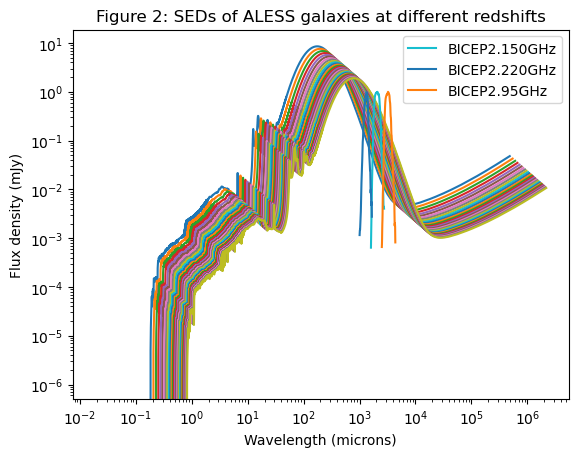

In [7]:
for z in zgrid:
    plt.plot(data['wave'] * (1+z), data['fnu']/(1+z))
for file in biceplist:
    bicep = at.Table.read('bicep/'+file, format='ascii', data_start=1)
    wave = (bicep['col1'] * u.Angstrom).to(u.micron)
    fnu = (bicep['col2'])
    plt.plot(wave.value, fnu.value,label=file[6:-4])
plt.loglog()
plt.xlabel('Wavelength (microns)')
plt.ylabel('Flux density (mJy)')
plt.title('Figure 2: SEDs of ALESS galaxies at different redshifts')
plt.legend()
plt.show()

# Q2 - Supernovae and $H_0$ (40 pts - 10 per part)

For this simulation, we will generate a sample of type Ia supernovae. These are special as they have similar intrinsic brightness, so that their apparent flux can be used to measure how far away they are. If their redshift is also measured, the measurements can be used to calculate the expansion rate of the Universe, or Hubble's constant.

We want to understand *how* brightness limits affect the use of type Ia supernovae observations in the measurement of the Hubble constant, $H_0$. To do so, we will use Monte Carlo computations to generate a set of simulated data. 

A subtle effect occurs in this measurement, called Malmquist bias, that can affect the result. The effect is caused by the range of apparent brightness for supernova. Supernova in our simulation have an absolute magnitude of M=-19. 

Assume the supernova have a scatter about their absolute magnitude of approximately 1 magnitude (this is much too large, but it is to exaggerate the effect we'll see). 1-2m class survey telescopes will detect objects as faint as m=21 in about a minute of exposure - treat this is as their reliable detection limit - i.e. sources <= 21 are detected 100% of the time. Sources > 21 are detected with 0% efficiency. This is obviously unrealistic, but it'll suffice for now.

The limiting magnitude corresponds to a distance modulus m-M=5 log10(d/10 pc) of 40, which suggests that supernova can be seen at least as far away as 1000 Mpc. 

(We will assume that over this distance, the SED of SNe Ia are approximately constant so we can happily neglect the $k$-correction, so you will not murder me after you have suffered through Q1)

Assume supernova are formed uniformly throughout *a sphere* with radius r=2500 Mpc. In the data generation part of the simulation, assume that each supernova is receding at a rate v=H0*d, where H0 is 72km/s/Mpc and d is the distance in Mpc. For each supernova you simulate, also create a peculiar velocity array that you can add to the recession velocity by drawing from a Gaussian distribution with mean 0, and standard deviation of 600 km/s. (Hint: "uniformly in a sphere" is definitely a trap and you should think about what you are doing)

1. Create a Monte Carlo program to generate 100 randomly placed supernovae within this volume. Have the program generate the true distances, $d$, to the supernovae. Calculate the mean distance for the supernovae.

2. Now assume each supernovae has a brightness governed by M = -19 +G(1) where G(1) is a random number with Gaussian distribution and standard deviation of one magnitude. Calculate the apparent magnitude of each supernovae using the distance generated in part (1). If m>21, assume the object is too faint to detect and reject it from the sample. Create a plot of magnitude versus distance for all the supernovae. Write out the *average* magnitudes of the original sample and the detected sample. 

3. Generate the velocities (both recession and peculiar) as described earlier. Generate an observed distance ($d'$) by using its apparent magnitude and Hubble’s law, with the *assumption* that the supernova has an absolute magnitude (M) of -19. Plot the observed distance on the x-axis and total velocity on the y-axis and compare it to the true distance. Explain the effect of the observing limit on the resulting sample. 

4. Calculate $H_0$ by fitting a line to all your detected points. Discuss the level of the bias from the fit you get to the true points. How much of an impact does the peculiar velocity have? How could you account for Malmquist bias and peculiar velocity in the observations? Repeat for N=1000, 10000 SNe (and as with Q1, make your code use approrpiate functions so you can just call it for different sample sizes) to see if the effects persist as a function of sample size. 

In [8]:
class SNEMonteCarlo():
    def __init__(self,numSNE):
        self.numSNE = numSNE
        self.H0 = 72 * u.km / u.s / u.Mpc
        self.rad = 2500 * u.Mpc
    
    def generateSNE(self):
        self.dists = np.random.uniform(0, 1, self.numSNE) * self.rad
        self.abs_mags = -19 + np.random.normal(0,1,self.numSNE)
        self.app_mags = self.abs_mags + 5*np.log10(self.dists.to('pc').value / 10)
        self.mag_mask = self.app_mags < 21
        self.app_mags_masked = self.app_mags[self.mag_mask]
        self.rec_v = self.H0 * self.dists[self.mag_mask]
        self.pec_v = np.random.normal(0,600,len(self.rec_v))
        self.tot_v = self.rec_v.value + self.pec_v
        self.obs_dist = 10 * 10**((self.app_mags_masked - (-19))/5) / 1e6
        print('Mean Distance of the Original Sample:', self.dists.mean())
        return self.obs_dist, self.tot_v
    
    def plotMags(self):
        plt.plot(self.app_mags[self.mag_mask],self.dists[self.mag_mask], '.')
        plt.ylabel('Distance (Mpc)')
        plt.xlabel('Apparent Magnitude')
        plt.title('Distance vs Apparent Magnitude')
        plt.gca().invert_xaxis()
        plt.show()
        print('Mean of Original Sample', self.app_mags.mean())
        print('Mean of Detected Sample', self.app_mags_masked.mean())

    def plotSNE(self):
        plt.plot(self.obs_dist,self.tot_v, '.',label='Observed')
        plt.plot(self.dists[self.mag_mask],self.tot_v, '.',label='True')
        plt.title('Observed Distance vs Total Velocity')
        plt.xlabel('Distance (Mpc)')
        plt.ylabel('Total Velocity (km/s)')
        plt.legend()
        plt.show()
    
    def fitH0(self):
        def Hfit(d,H):
            return d*H
        self.fit_h0 = sp.optimize.curve_fit(Hfit, self.obs_dist, self.tot_v, p0=72)[0][0]
        print('Fitted H0:', self.fit_h0)
    
    def runSim(self):
        self.generateSNE()
        self.plotMags()
        self.plotSNE()
        self.fitH0()

Mean Distance of the Original Sample: 1289.8270096686626 Mpc


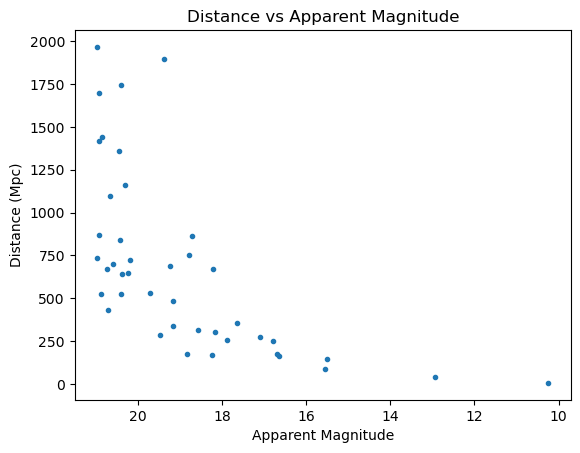

Mean of Original Sample 20.93034080712606
Mean of Detected Sample 18.927359633912495


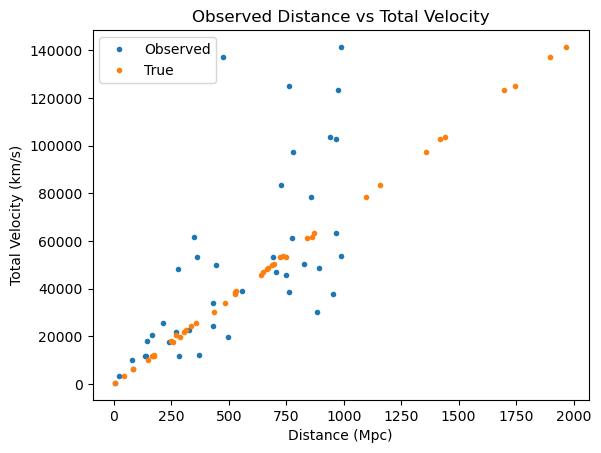

Fitted H0: 88.36962241560296


In [9]:
SNEMonteCarlo(100).runSim()

Mean Distance of the Original Sample: 1239.527002973617 Mpc


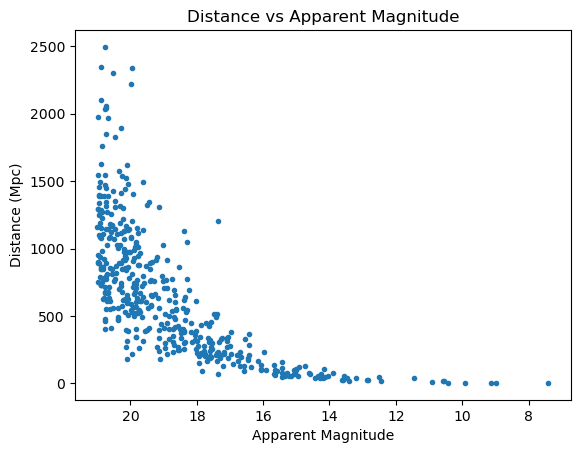

Mean of Original Sample 20.78284202942073
Mean of Detected Sample 18.73963351064615


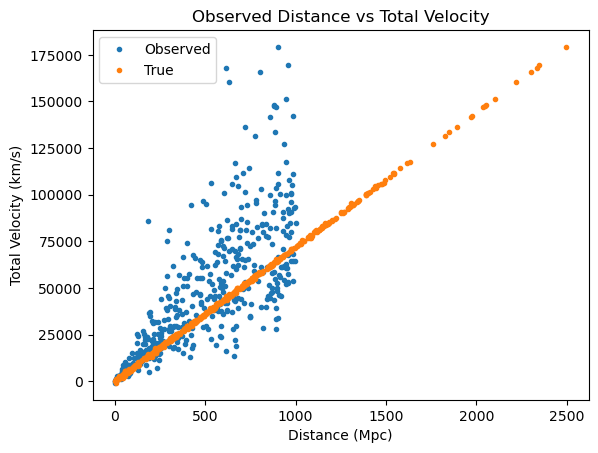

Fitted H0: 93.07359231947197


In [10]:
SNEMonteCarlo(1000).runSim()

Mean Distance of the Original Sample: 1257.8462554260664 Mpc


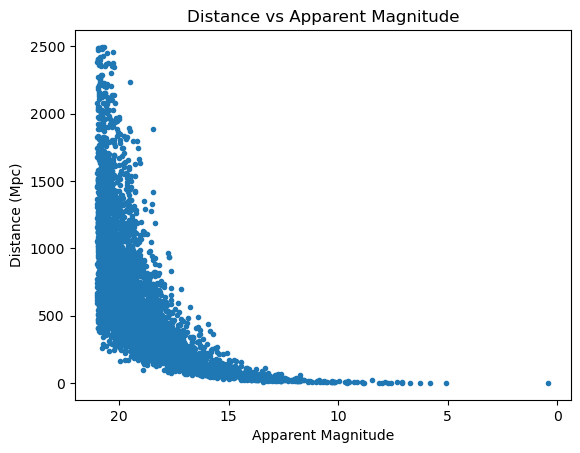

Mean of Original Sample 20.849009788422556
Mean of Detected Sample 18.85545838400434


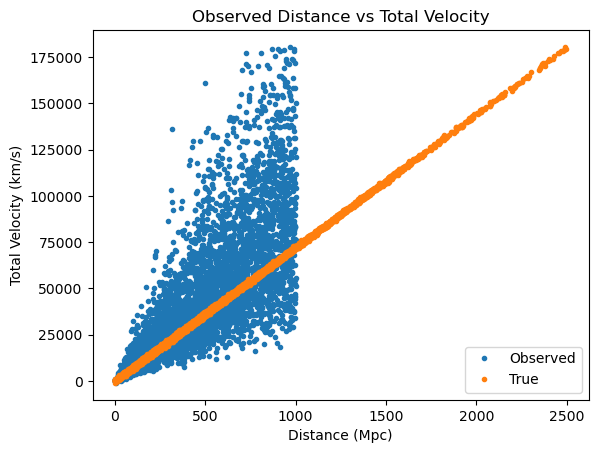

Fitted H0: 94.8758685810144


In [11]:
SNEMonteCarlo(10000).runSim()

From these observations, we see that as the number of Supernovae increase, the limiting of the magnitudes becomes more apparent. We can see that for greater magnitudes (and greater distances), the Supernovae are rejected. This leads to a very ill fitting H0 that we calculated, with values around 90 km/s/Mpc. There is quite a high level of bias from the observed points, as there is a lot of random noise in the data. The peculiar velocities add to this, but not to a very high amount. This bias leads to a fitted H0 which is almost 20 above that of the known value. The observing limit adds to this, as it prevents the sample from fitting the model beyond a distance of around 1000 Mpc.

### Divide and conquer, so you encounter issues in parallel and can explain things to each other, rather than working in series. 

# Due Oct 1 at Noon!